<a href="https://colab.research.google.com/github/HappyBearDay/Deep_Learning_Image_Multi_label/blob/master/image_project_our_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA20001 Deep Learning - Group Project
## Image project

**Due Thursday, December 13, before 23:59.**

The task is to learn to assign the correct labels to a set of images.  The images are originally from a photo-sharing site and released under Creative Commons-licenses allowing sharing.  The training set contains 20 000 images. We have resized them and cropped them to 128x128 to make the task a bit more manageable.

We're only giving you the code for downloading the data. The rest you'll have to do yourselves.

Some comments and hints particular to the image project:

- One image may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are images that don't belong to any of our classes, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.

- As the dataset is pretty imbalanced, don't focus too strictly on the outputs being probabilistic. (Meaning that the right threshold for selecting the label might not be 0.5.)

- Image files can be loaded as numpy matrices for example using `imread` from `matplotlib.pyplot`. Most images are color, but a few grayscale. You need to handle the grayscale ones somehow as they would have a different number of color channels (depth) than the color ones.

- In the exercises we used e.g., `torchvision.datasets.MNIST` to handle the loading of the data in suitable batches. Here, you need to handle the dataloading yourself.  The easiest way is probably to create a custom `Dataset`. [See for example here for a tutorial](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
! pip install torch torchvision torchsummary

    100% |████████████████████████████████| 591.8MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61e5c000 @  0x7f32677622a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 20.0MB/s 
    100% |████████████████████████████████| 2.0MB 5.7MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [4]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

    100% |████████████████████████████████| 5.7MB 5.4MB/s 
  Found existing installation: Pillow 5.4.0
    Uninstalling Pillow-5.4.0:
      Successfully uninstalled Pillow-5.4.0


## Download the data

In [0]:
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
import zipfile

In [6]:
train_path = 'train'
dl_file = 'dl2018-image-proj.zip'
dl_url = 'https://users.aalto.fi/mvsjober/misc/'

zip_path = os.path.join(train_path, dl_file)
if not os.path.isfile(zip_path):
    download_url(dl_url + dl_file, root=train_path, filename=dl_file, md5=None)

with zipfile.ZipFile(zip_path) as zip_f:
    zip_f.extractall(train_path)
    #os.unlink(zip_path)

In [7]:
if torch.cuda.is_available():
    print('Using GPU!')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

Using GPU!


The above command downloaded and extracted the data files into the `train` subdirectory.

The images can be found in `train/images`, and are named as `im1.jpg`, `im2.jpg` and so on until `im20000.jpg`.

The class labels, or annotations, can be found in `train/annotations` as `CLASSNAME.txt`, where CLASSNAME is one of the fourteen classes: *baby, bird, car, clouds, dog, female, flower, male, night, people, portrait, river, sea,* and *tree*.

Each annotation file is a simple text file that lists the images that depict that class, one per line. The images are listed with their number, not the full filename. For example `5969` refers to the image `im5969.jpg`.

## Your stuff goes here ...

In [0]:
import os
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random as rd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
img_path = "./train/images/"
labels_path = "./train/annotations/"

Get all annotations & images paths

In [0]:
images_path = "train/images/" 
image_files = [(images_path+f) for f in os.listdir(images_path) \
                if os.path.isfile(os.path.join(images_path, f))]
images = []
for current_img_path in image_files:
    current_img_vector =  plt.imread( current_img_path )
    filename_without_extension = os.path.basename(current_img_path)[:-4] # :-4 to drop the extension
    img_num = filename_without_extension[2:] # drop the heading "im"
    images += [img_num]
del image_files

In [0]:
data=images
labels = [[] for _ in range(len(data))] # Empty list of labels
annotations_path = "train/annotations/"
annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
        if os.path.isfile(os.path.join(annotations_path, f))]
for file in annotations_files:
    label = os.path.basename(file)[:-4] # :-4 to drop the extension
    with open(file) as f: # file is the name of the label currently read
        img_nums = f.read().split()
    for img_num in img_nums:
        if img_num not in data:
            continue
        labels[data.index(img_num)].append(label)

In [0]:
class OneHotTransformer:
    def __init__(self):
        annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
                    if os.path.isfile(os.path.join(annotations_path, f))]
        self.vocabulary = []
        for file in annotations_files:
            label = os.path.basename(file)[:-4] # :-4 to drop the extension
            self.vocabulary.append(label)
    def toOneHot(self, labels):
        res = [0]*len(self.vocabulary)
        for i, voc in enumerate(self.vocabulary):
            if voc in labels:
                res[i] = 1
        return np.array(res)
    def toVocabulary(self, onehot):
        res = []
        for i, n in enumerate(onehot):
            if n: res.append(self.vocabulary[i])
        return res
oneHotTransformer = OneHotTransformer()

In [0]:
# Files to pytorch dataset
# Inspired from https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms
from PIL import Image

class imageDataset(Dataset):
    def __init__(self, data_basenames, channels = 3, height = 224, width = 224, transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])):
        """
        data_basenames is a list of id of image, such as ["9885", "9886"]
        transforms is a list of transformation. it last element should be transforms.ToTensor()
        """
        def parse_labels(data_paths):
            """ Parse to one hot """
            labels = [[] for _ in range(len(data_paths))] # Empty list of labels
            annotations_path = "train/annotations/"
            annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
                    if os.path.isfile(os.path.join(annotations_path, f))]
            vocabulary = []
            for file in annotations_files:
                label = os.path.basename(file)[:-4] # :-4 to drop the extension
                vocabulary.append(label)
                with open(file) as f: # file is the name of the label currently read
                    img_nums = f.read().split()
                for img_num in img_nums:
                    if img_num not in data_paths:
                        continue
                    labels[data_paths.index(img_num)].append(label)
            return labels
          
        self.data = data_basenames
        self.labels = parse_labels(data_basenames)
        self.channels = channels
        self.height = height
        self.width = width
        self.transforms = transforms
        self.data_len = len(data_basenames)

    def __getitem__(self, index):
        img_path = "train/images/im" + self.data[index] + ".jpg"
        data = Image.open(img_path)
        
        if self.transforms is not None:
            img = self.transforms(data)
        #labels = np.array(self.labels[index])
        #print(self.labels[index])
        
        if img.shape[0] == 1:  # change graysclae images to RGB
            img = torch.cat((img,img,img),0)      
        labels = self.labels[index]
        one_hot_labels = oneHotTransformer.toOneHot(labels)
        return img, one_hot_labels

    def __len__(self):
        return self.data_len

    
import random
random.shuffle(images) # So we make sure test data has all kinds of label, in case
                                 # the repartition is not even according to label names

batch_size = 16

# 80% train, 20% test
index_cut =  int(len(images)*0.8)
train_dataset = imageDataset(images[:index_cut])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
test_dataset = imageDataset(images[index_cut:])
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [0]:
data, target = next(train_loader.__iter__()) # Iteration works!

# Model start

## 1. CNN architectures



### 1.1 Single CNN architecture

In [0]:
class one_layer_cnn(nn.Module):
    def __init__(self, nclass = 14):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size = 3,padding = 0,stride = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.fc1 = nn.Linear(16*111*111, 16*111)
        self.fc2 = nn.Linear(16*111, nclass)
        
    def forward(self,x):
        out = self.layer1(x)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = one_layer_cnn().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (3, 224, 224))

one_layer_cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=197136, out_features=1776, bias=True)
  (fc2): Linear(in_features=1776, out_features=14, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 222, 222]             448
       BatchNorm2d-2         [-1, 16, 222, 222]              32
              ReLU-3         [-1, 16, 222, 222]               0
         MaxPool2d-4         [-1, 16, 111, 111]               0
            Linear-5                 [-1, 1776]     350,115,312
            Linear-6                   [-1, 14]          24,878
Total params: 350,140,670
Trainable params: 350,140,670
Non-trainab

In [0]:
def train_net(model, epoch, trainLoss, thresh, interval = 100):
    # set model to train
    model.train()
    loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data = data.to(device) # to GPU
        target = target.float().to(device) # to GPU, ".float()" is improtant, otherwise got error.
        
        # set zero gradient buffer
        optimizer.zero_grad()
        
        # compute the output and Loss
        output = model(data)
        Loss = criterion(output, target)
        
        # back prop
        Loss.backward()
        
        # update weights
        optimizer.step()
        
        # print information
        if batch_idx % interval == 0:
            print("Train Epoch: {} [{}/{} {:.0f}%]\tLoss: {:.6f}".format(epoch, len(data)*batch_idx, len(train_loader)*len(data), batch_idx/len(train_loader)*100, Loss.data.item()))   
         
        loss += Loss
        
    loss/=len(train_loader)
    
    trainLoss.append(loss)

In [0]:
def validate(model, treshold, lossv, accv, precv, recv, verbose=True):
  loss, acc, prec, rec = 0,0,0,0
  for i, sample in enumerate(test_loader):
    inputv, targetv = sample
    inputv = inputv.to(device)
    output = model(inputv)
    
    pred = torch.sigmoid(output).data.gt(treshold) # Activated output
    #loss += criterion(output, target.float().to(device))
    loss += criterion(output, targetv.data.to(device).float()).data.item()
    # confusion matrix (true/false negative/positive)
    tp = (pred + targetv.data.to(device).byte()).eq(2).sum()
    fp = (pred - targetv.data.to(device).byte()).eq(1).sum()
    fn = (pred - targetv.data.to(device).byte()).eq(-1).sum()
    tn = (pred + targetv.data.to(device).byte()).eq(0).sum()
    acc += (tp + tn).float() / (tp + tn + fp + fn)

    if tp+fp!=0:
      prec += tp.float() / (tp + fp)
    else:
      prec += 0.0
    if tp+fn != 0:
      rec += tp.float() / (tp + fn)
    else:
      rec += 0.0
  loss /= len(test_loader)
  acc /= len(test_loader)
  prec /= len(test_loader)
  rec /= len(test_loader)
  lossv.append(loss)
  accv.append(acc)
  precv.append(prec)
  recv.append(rec)
  if verbose:
    print('Validation set: Average loss: {:.4f}, Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%'.format(
            loss, acc*100, prec*100, rec*100))
    print("\t\tF1 score : {:.2f}%\n".format(100*2*(prec*rec)/(prec+rec)))

In [0]:
treshold = 0.5
epoch = 10

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.000001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()

train_loss, val_loss = [], []
accuracy, precision, recall = [],[],[]


for i in range(1,1+epoch):
    train_net(model, i, train_loss, treshold)
    validate(model, treshold, val_loss, accuracy, precision, recall)
    
    if i>3:
        prev_delta_loss = abs(val_loss[-2] - train_loss[-2]) 
        delta_loss = abs(val_loss[-1] - train_loss[-1])

Train Epoch: 1 [0/16000 0%]	Loss: 0.694478
Train Epoch: 1 [1600/16000 10%]	Loss: 0.225105
Train Epoch: 1 [3200/16000 20%]	Loss: 0.276353
Train Epoch: 1 [4800/16000 30%]	Loss: 0.253154
Train Epoch: 1 [6400/16000 40%]	Loss: 0.147454
Train Epoch: 1 [8000/16000 50%]	Loss: 0.173057
Train Epoch: 1 [9600/16000 60%]	Loss: 0.160469
Train Epoch: 1 [11200/16000 70%]	Loss: 0.259119
Train Epoch: 1 [12800/16000 80%]	Loss: 0.174156
Train Epoch: 1 [14400/16000 90%]	Loss: 0.171694
Validation set: Average loss: 0.2066, Accuracy: 92.78%, Precision: 42.53%, Recall: 5.74%
		F1 score : 10.12%

Train Epoch: 2 [0/16000 0%]	Loss: 0.191228
Train Epoch: 2 [1600/16000 10%]	Loss: 0.243373
Train Epoch: 2 [3200/16000 20%]	Loss: 0.108537
Train Epoch: 2 [4800/16000 30%]	Loss: 0.268760
Train Epoch: 2 [6400/16000 40%]	Loss: 0.195342
Train Epoch: 2 [8000/16000 50%]	Loss: 0.279117
Train Epoch: 2 [9600/16000 60%]	Loss: 0.170338
Train Epoch: 2 [11200/16000 70%]	Loss: 0.171292
Train Epoch: 2 [12800/16000 80%]	Loss: 0.151107


### 1.2 Simple cnn 2

In [128]:
class simple_cnn2(nn.Module):
    def __init__(self, nclass = 14):
        super(simple_cnn2,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size = 11,padding = 0,stride = 4),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size = 5,padding = 0,stride = 2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        self.fc1 = nn.Linear(5*5*128, 128)
        self.fc2 = nn.Linear(128, nclass)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0),-1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out
      
model = simple_cnn2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (3, 224, 224))

simple_cnn2(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=3200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=14, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 54, 54]          23,296
       BatchNorm2d-2           [-1, 64, 54, 54]             128
              ReLU-3           [-1, 64, 54, 54]  

In [129]:
%%time
#model = one_layer_cnn().to(device)
#model = sim_cnn_v1().to(device)
#model = deep_cnn().to(device)
#model = lstm()
treshold = 0.3
epoch = 30

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.0001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()
train_loss, val_loss = [], []
accuracy, precision, recall = [],[],[]
for i in range(1,1+epoch):
    train_net(model, i, train_loss, treshold)
    validate(model, treshold, val_loss, accuracy, precision, recall)
    torch.save(model.state_dict(), '/content/gdrive/My Drive/Image_project/model_simcnn2_epoch'+str(i)+'.pkl')
    
    if i>3:
      prev_delta_loss = abs(val_loss[-2] - train_loss[-2]) 
      delta_loss = abs(val_loss[-1] - train_loss[-1])
      if delta_loss > prev_delta_loss:
        # The model starts to be overfitted
        #if delta_loss<0.01:
        #  break # We consider a 0.01 delta loss good enough
        #elif delta_loss<0.5: 
        #  print("Smaller learning rate!")
        #  learning_rate /= 10 # Dividing the learning rate
        # optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
        pass

Train Epoch: 1 [0/16000 0%]	Loss: 0.697739
Train Epoch: 1 [1600/16000 10%]	Loss: 0.200957
Train Epoch: 1 [3200/16000 20%]	Loss: 0.185075
Train Epoch: 1 [4800/16000 30%]	Loss: 0.222508
Train Epoch: 1 [6400/16000 40%]	Loss: 0.251575
Train Epoch: 1 [8000/16000 50%]	Loss: 0.287641
Train Epoch: 1 [9600/16000 60%]	Loss: 0.187543
Train Epoch: 1 [11200/16000 70%]	Loss: 0.186691
Train Epoch: 1 [12800/16000 80%]	Loss: 0.152598
Train Epoch: 1 [14400/16000 90%]	Loss: 0.200864
Validation set: Average loss: 0.1903, Accuracy: 91.05%, Precision: 38.88%, Recall: 44.64%
		F1 score : 41.56%

Train Epoch: 2 [0/16000 0%]	Loss: 0.116632
Train Epoch: 2 [1600/16000 10%]	Loss: 0.195112
Train Epoch: 2 [3200/16000 20%]	Loss: 0.105548
Train Epoch: 2 [4800/16000 30%]	Loss: 0.138620
Train Epoch: 2 [6400/16000 40%]	Loss: 0.238428
Train Epoch: 2 [8000/16000 50%]	Loss: 0.252632
Train Epoch: 2 [9600/16000 60%]	Loss: 0.152694
Train Epoch: 2 [11200/16000 70%]	Loss: 0.133450
Train Epoch: 2 [12800/16000 80%]	Loss: 0.162424

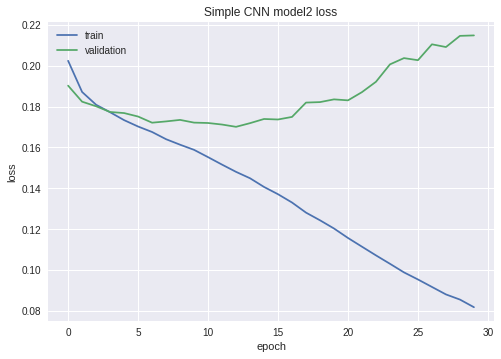

In [131]:
plt.title("Simple CNN model2 loss")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

looks still overfit

#### 1.2.1 with dropout

In [139]:
class simple_cnn2_drop(nn.Module):
    def __init__(self, nclass = 14):
        super(simple_cnn2_drop,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size = 11,padding = 0,stride = 4),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size = 5,padding = 0,stride = 2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(5*5*128, 128)
        self.fc2 = nn.Linear(128, nclass)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.dropout(out)
        out = out.view(out.size(0),-1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out
      
model = simple_cnn2_drop().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (3, 224, 224))

simple_cnn2_drop(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.5)
  (fc1): Linear(in_features=3200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=14, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 54, 54]          23,296
       BatchNorm2d-2           [-1, 64, 54, 54]             128
              Re

In [133]:
%%time
#model = one_layer_cnn().to(device)
#model = sim_cnn_v1().to(device)
#model = deep_cnn().to(device)
#model = lstm()
treshold = 0.3
epoch = 20

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.00001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()
train_loss, val_loss = [], []
accuracy, precision, recall = [],[],[]
for i in range(1,1+epoch):
    train_net(model, i, train_loss, treshold)
    validate(model, treshold, val_loss, accuracy, precision, recall)
    torch.save(model.state_dict(), '/content/gdrive/My Drive/Image_project/model_simcnn2_drop_epoch'+str(i)+'.pkl')
    
    if i>3:
      prev_delta_loss = abs(val_loss[-2] - train_loss[-2]) 
      delta_loss = abs(val_loss[-1] - train_loss[-1])
      if delta_loss > prev_delta_loss:
        # The model starts to be overfitted
        #if delta_loss<0.01:
        #  break # We consider a 0.01 delta loss good enough
        #elif delta_loss<0.5: 
        #  print("Smaller learning rate!")
        #  learning_rate /= 10 # Dividing the learning rate
        # optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
        pass

Train Epoch: 1 [0/16000 0%]	Loss: 0.734386
Train Epoch: 1 [1600/16000 10%]	Loss: 0.400717
Train Epoch: 1 [3200/16000 20%]	Loss: 0.251499
Train Epoch: 1 [4800/16000 30%]	Loss: 0.253158
Train Epoch: 1 [6400/16000 40%]	Loss: 0.194982
Train Epoch: 1 [8000/16000 50%]	Loss: 0.182945
Train Epoch: 1 [9600/16000 60%]	Loss: 0.225766
Train Epoch: 1 [11200/16000 70%]	Loss: 0.273282
Train Epoch: 1 [12800/16000 80%]	Loss: 0.216732
Train Epoch: 1 [14400/16000 90%]	Loss: 0.174309
Validation set: Average loss: 0.2092, Accuracy: 91.33%, Precision: 35.17%, Recall: 24.48%
		F1 score : 28.87%

Train Epoch: 2 [0/16000 0%]	Loss: 0.156967
Train Epoch: 2 [1600/16000 10%]	Loss: 0.170781
Train Epoch: 2 [3200/16000 20%]	Loss: 0.244647
Train Epoch: 2 [4800/16000 30%]	Loss: 0.167825
Train Epoch: 2 [6400/16000 40%]	Loss: 0.200741
Train Epoch: 2 [8000/16000 50%]	Loss: 0.187942
Train Epoch: 2 [9600/16000 60%]	Loss: 0.205391
Train Epoch: 2 [11200/16000 70%]	Loss: 0.176218
Train Epoch: 2 [12800/16000 80%]	Loss: 0.222907

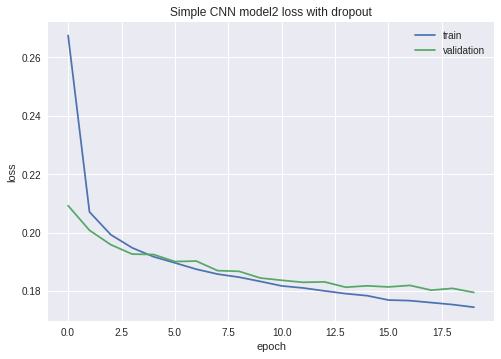

In [134]:
plt.title("Simple CNN model2 loss with dropout")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [140]:
%%time
#model = one_layer_cnn().to(device)
#model = sim_cnn_v1().to(device)
#model = deep_cnn().to(device)
#model = lstm()
treshold = 0.3
epoch = 20

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.0001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()
train_loss, val_loss = [], []
accuracy, precision, recall = [],[],[]
for i in range(1,1+epoch):
    train_net(model, i, train_loss, treshold)
    validate(model, treshold, val_loss, accuracy, precision, recall)
    torch.save(model.state_dict(), '/content/gdrive/My Drive/Image_project/model_simcnn2_drop2_epoch'+str(i)+'.pkl')
    
    if i>3:
      prev_delta_loss = abs(val_loss[-2] - train_loss[-2]) 
      delta_loss = abs(val_loss[-1] - train_loss[-1])
      if delta_loss > prev_delta_loss:
        # The model starts to be overfitted
        #if delta_loss<0.01:
        #  break # We consider a 0.01 delta loss good enough
        #elif delta_loss<0.5: 
        #  print("Smaller learning rate!")
        #  learning_rate /= 10 # Dividing the learning rate
        # optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
        pass

Train Epoch: 1 [0/16000 0%]	Loss: 0.699267
Train Epoch: 1 [1600/16000 10%]	Loss: 0.147568
Train Epoch: 1 [3200/16000 20%]	Loss: 0.236901
Train Epoch: 1 [4800/16000 30%]	Loss: 0.148070
Train Epoch: 1 [6400/16000 40%]	Loss: 0.191657
Train Epoch: 1 [8000/16000 50%]	Loss: 0.182377
Train Epoch: 1 [9600/16000 60%]	Loss: 0.170859
Train Epoch: 1 [11200/16000 70%]	Loss: 0.202445
Train Epoch: 1 [12800/16000 80%]	Loss: 0.234823
Train Epoch: 1 [14400/16000 90%]	Loss: 0.210743
Validation set: Average loss: 0.1893, Accuracy: 91.78%, Precision: 40.95%, Recall: 35.61%
		F1 score : 38.10%

Train Epoch: 2 [0/16000 0%]	Loss: 0.204171
Train Epoch: 2 [1600/16000 10%]	Loss: 0.206055
Train Epoch: 2 [3200/16000 20%]	Loss: 0.209324
Train Epoch: 2 [4800/16000 30%]	Loss: 0.230996
Train Epoch: 2 [6400/16000 40%]	Loss: 0.219722
Train Epoch: 2 [8000/16000 50%]	Loss: 0.149637
Train Epoch: 2 [9600/16000 60%]	Loss: 0.222880
Train Epoch: 2 [11200/16000 70%]	Loss: 0.166373
Train Epoch: 2 [12800/16000 80%]	Loss: 0.215509

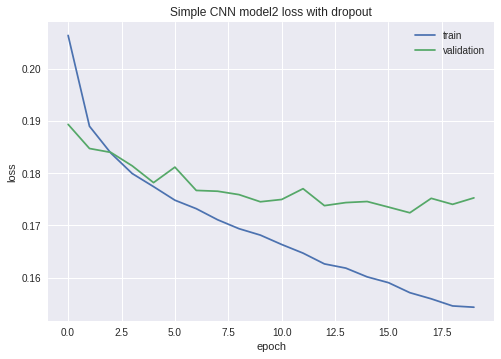

In [141]:
plt.title("Simple CNN model2 loss with dropout")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

### 1.3 Simple CNN 3

In [144]:
class simple_cnn3(nn.Module):
    def __init__(self, nclass = 14):
        super(simple_cnn3,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size = 11,padding = 0,stride = 4),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size = 5,padding = 0,stride = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(5*5*32, nclass)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.dropout(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        return out
      
model = simple_cnn3().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (3, 224, 224))

simple_cnn3(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.5)
  (fc1): Linear(in_features=800, out_features=14, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 54, 54]           5,824
       BatchNorm2d-2           [-1, 16, 54, 54]              32
              ReLU-3           [-1, 16, 54, 54]               0
         MaxPool2d-4  

In [145]:
%%time
#model = one_layer_cnn().to(device)
#model = sim_cnn_v1().to(device)
#model = deep_cnn().to(device)
#model = lstm()
treshold = 0.3
epoch = 30

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.0001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()
train_loss, val_loss = [], []
accuracy, precision, recall = [],[],[]
for i in range(1,1+epoch):
    train_net(model, i, train_loss, treshold)
    validate(model, treshold, val_loss, accuracy, precision, recall)
    torch.save(model.state_dict(), '/content/gdrive/My Drive/Image_project/model_simcnn3_epoch'+str(i)+'.pkl')
    
    if i>3:
      prev_delta_loss = abs(val_loss[-2] - train_loss[-2]) 
      delta_loss = abs(val_loss[-1] - train_loss[-1])

Train Epoch: 1 [0/16000 0%]	Loss: 0.719025
Train Epoch: 1 [1600/16000 10%]	Loss: 0.270254
Train Epoch: 1 [3200/16000 20%]	Loss: 0.229194
Train Epoch: 1 [4800/16000 30%]	Loss: 0.211352
Train Epoch: 1 [6400/16000 40%]	Loss: 0.260475
Train Epoch: 1 [8000/16000 50%]	Loss: 0.212612
Train Epoch: 1 [9600/16000 60%]	Loss: 0.158818
Train Epoch: 1 [11200/16000 70%]	Loss: 0.223330
Train Epoch: 1 [12800/16000 80%]	Loss: 0.181084
Train Epoch: 1 [14400/16000 90%]	Loss: 0.215438
Validation set: Average loss: 0.2043, Accuracy: 91.71%, Precision: 37.60%, Recall: 24.07%
		F1 score : 29.35%

Train Epoch: 2 [0/16000 0%]	Loss: 0.281831
Train Epoch: 2 [1600/16000 10%]	Loss: 0.192262
Train Epoch: 2 [3200/16000 20%]	Loss: 0.165279
Train Epoch: 2 [4800/16000 30%]	Loss: 0.166773
Train Epoch: 2 [6400/16000 40%]	Loss: 0.199411
Train Epoch: 2 [8000/16000 50%]	Loss: 0.179614
Train Epoch: 2 [9600/16000 60%]	Loss: 0.179115
Train Epoch: 2 [11200/16000 70%]	Loss: 0.200275
Train Epoch: 2 [12800/16000 80%]	Loss: 0.167071

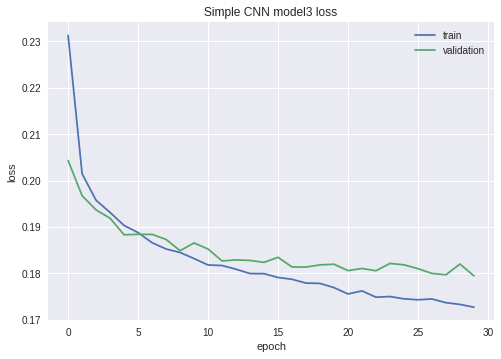

In [146]:
plt.title("Simple CNN model3 loss")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

### 2.1 Deep CNN

In [125]:
class deep_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(10, stride=3)
        )
        #self.fc1 = nn.Linear(4096, 20)
        self.lastlayer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(5*5*64, 14)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        #out = self.conv4(out)
        out = out.view(out.size(0),-1)
        out = self.lastlayer(out)
        return out
model = deep_cnn().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (3, 224, 224))

deep_cnn(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [126]:
%%time
#model = one_layer_cnn().to(device)
#model = sim_cnn_v1().to(device)
#model = deep_cnn().to(device)
#model = lstm()
treshold = 0.3
epoch = 30

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.0001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()
train_loss, val_loss = [], []
accuracy, precision, recall = [],[],[]
for i in range(1,1+epoch):
    train_net(model, i, train_loss, treshold)
    validate(model, treshold, val_loss, accuracy, precision, recall)
    torch.save(model.state_dict(), '/content/gdrive/My Drive/Image_project/model_deepcnno_epoch'+str(i)+'.pkl')
    
    if i>3:
      prev_delta_loss = abs(val_loss[-2] - train_loss[-2]) 
      delta_loss = abs(val_loss[-1] - train_loss[-1])

Train Epoch: 1 [0/16000 0%]	Loss: 0.684552
Train Epoch: 1 [1600/16000 10%]	Loss: 0.237730
Train Epoch: 1 [3200/16000 20%]	Loss: 0.228479
Train Epoch: 1 [4800/16000 30%]	Loss: 0.231039
Train Epoch: 1 [6400/16000 40%]	Loss: 0.228270
Train Epoch: 1 [8000/16000 50%]	Loss: 0.201196
Train Epoch: 1 [9600/16000 60%]	Loss: 0.171441
Train Epoch: 1 [11200/16000 70%]	Loss: 0.251514
Train Epoch: 1 [12800/16000 80%]	Loss: 0.189196
Train Epoch: 1 [14400/16000 90%]	Loss: 0.201751
Validation set: Average loss: 0.1948, Accuracy: 91.82%, Precision: 40.43%, Recall: 30.91%
		F1 score : 35.04%

Train Epoch: 2 [0/16000 0%]	Loss: 0.199817
Train Epoch: 2 [1600/16000 10%]	Loss: 0.193014
Train Epoch: 2 [3200/16000 20%]	Loss: 0.190237
Train Epoch: 2 [4800/16000 30%]	Loss: 0.221923
Train Epoch: 2 [6400/16000 40%]	Loss: 0.201448
Train Epoch: 2 [8000/16000 50%]	Loss: 0.269272
Train Epoch: 2 [9600/16000 60%]	Loss: 0.191121
Train Epoch: 2 [11200/16000 70%]	Loss: 0.206648
Train Epoch: 2 [12800/16000 80%]	Loss: 0.231596

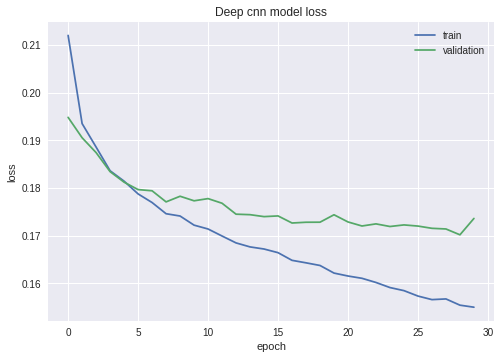

In [127]:
plt.title("Deep cnn model loss")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [0]:
torch.save(model.state_dict(), 'model.pkl')

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".  [See more here on how to load the model back](https://github.com/pytorch/pytorch/blob/761d6799beb3afa03657a71776412a2171ee7533/docs/source/notes/serialization.rst) if you want to continue training later.

In [0]:
# Have a look at results
# So we can know what error is common
for i, sample in enumerate(test_loader):
    inputv, targetv = sample
    inputv = inputv.to(device)
    output = model(inputv)
    
    #print("Prediction\n", output)
    pred = torch.sigmoid(output).data.gt(treshold) # Activated output
    print("Prediction\n", pred)
    print("Truth\n", targetv)
    break

Prediction
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0',
       dtype=torch.uint8)
Truth
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 

## Download test set

The testset will be made available during the last week before the deadline and can be downloaded in the same way as the training set.

## Predict for test set

You should return your predictions for the test set in a plain text file.  The text file contains one row for each test set image.  Each row contains a binary prediction for each label (separated by a single space), 1 if it's present in the image, and 0 if not. The order of the labels is as follows (alphabetic order of the label names):

    baby bird car clouds dog female flower male night people portrait river sea tree

An example row could like like this if your system predicts the presense of a bird and clouds:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0
    
The order of the rows should be according to the numeric order of the image numbers.  In the test set, this means that the first row refers to image `im20001.jpg`, the second to `im20002.jpg`, and so on.

If you have the prediction output matrix prepared in `y` you can use the following function to save it to a text file.

In [0]:
np.savetxt('results.txt', y, fmt='%d')